In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torchvision
from torch import nn, optim
from torch.autograd import Variable as V
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
print('PyTorch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)
print('Is GPU available:', torch.cuda.is_available())

PyTorch version: 0.4.1
torchvision version: 0.2.1
Is GPU available: True


In [2]:
# hyperparameters
n_epochs = 10
batchsize = 128
learning_rate = 0.001
use_gpu = torch.cuda.is_available() # CUDA環境があるかどうか

In [3]:
# データセットの読み込み、PyTorchのTensorに変換、正規化(-1 ~ 1)、ミニバッチSGDのためのデータローダーの作成
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar10_train = datasets.CIFAR10(root = './data',
                             train = True,
                             transform = tf,
                             download = True)
cifar10_valid = datasets.CIFAR10(root = './data',
                            train = False,
                            transform = tf)
mnist_train_loader = DataLoader(cifar10_train, batch_size = batchsize, shuffle = True, num_workers = 4)
mnist_valid_loader = DataLoader(cifar10_valid, batch_size = batchsize, shuffle = False, num_workers = 4)
# num_workersはCPUでコア数が複数あると読み込みが速くなるらしい？（未検証）
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] # cifaf10のクラス
print(classes)
print('train_data:', len(cifar10_train))
print('validation_data:', len(cifar10_valid))

Files already downloaded and verified
['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
train_data: 50000
validation_data: 10000


tensor([[2, 2, 7, 3, 1],
        [7, 3, 9, 7, 6],
        [1, 8, 5, 1, 3],
        [7, 0, 0, 2, 4],
        [7, 3, 3, 0, 9]])
[['bird' 'bird' 'horse' 'cat' 'car']
 ['horse' 'cat' 'truck' 'horse' 'frog']
 ['car' 'ship' 'dog' 'car' 'cat']
 ['horse' 'plane' 'plane' 'bird' 'deer']
 ['horse' 'cat' 'cat' 'plane' 'truck']]


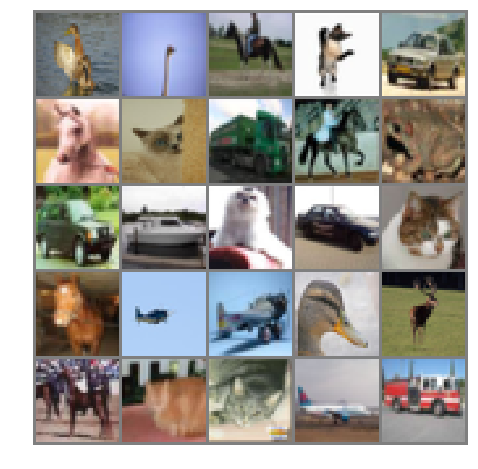

In [4]:
# データの可視化
def imshow(img):
    npimg = img.numpy() * 0.5 + 0.5 # 描画のために正規化を一旦戻す
    plt.figure(figsize = (8,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # PyTorchでは画像は(チャネル数、縦、横)でpltでは(縦、横、チャネル数）なのでひっくり返している
n_show = 25 # 表示するデータの数
n_row = 5 # 列数　多分n_showが自然数nの2乗で、n_rowがnじゃないとうまくいかないかも
images, labels = iter(mnist_train_loader).next()
images, labels = images[:n_show], labels[:n_show]
labels_name = np.array([classes[l] for l in labels.numpy()]).reshape(n_row, n_row)
imshow(make_grid(images, nrow = n_row, padding = 1)) # make_gridは複数の画像をいい感じに結合してくれる
plt.axis('off')
print(labels.view(-1, n_row))
print(labels_name)

In [5]:
# Cifar10分類のための畳み込みニューラルネットワーク
# メモ　reluみたいな活性化関数は__init__領域でフィールドとして宣言しなくてもtorch.nn.functional.reluのようにして
#      forward層に書くだけで使える。
#      これはdropoutなどその他のパラメータを持たないNNの要素についても同じだが、torch.nn.functionalの方のを使うと
#      モデルを.train()と.evan()で切り替えた時に適切に切り替えが為されないらしい(例えば評価時にもdropoutが入ってしまう)

# モデルの定義方法はほぼchainerと同じ。__call__とforwardの違いくらい
class CNN_CIFAR10(nn.Module):
    def __init__(self):
        super(CNN_CIFAR10, self).__init__()
        # nn.Sequentialでkeras的に複数のレイヤーをまとめて扱える
        self.layers1 = nn.Sequential(
                            nn.Conv2d(3, 32, kernel_size = 5, stride = 1, padding = 2),
                            # kernelsize5, padding2でサイズ変化なしで畳み込み
                            nn.BatchNorm2d(32), # バッチノーマライゼーション、引数はチャネルの数
                            nn.LeakyReLU(0.1), # LeakyReLU, 引数は負の領域の傾き
                            nn.MaxPool2d(kernel_size = 2, stride = 2)
                            # kernelsize2, stride2でサイズを幅/高さともに半分にしてプーリング
                        )
        self.layers2 = nn.Sequential(
                            nn.Conv2d(32, 64, kernel_size = 5, stride = 1, padding = 2),
                            nn.BatchNorm2d(64),
                            nn.LeakyReLU(0.1),
                            nn.MaxPool2d(kernel_size = 2, stride = 2)
                        )
        self.layers3 = nn.Sequential(
                            nn.Conv2d(64, 128, kernel_size = 5, stride = 1, padding = 2),
                            nn.BatchNorm2d(128),
                            nn.LeakyReLU(0.1),
                            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        # 畳み込み終わったのを1次元にまとめて全結合層に入れ、10クラスまで落とす
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.rl = nn.LeakyReLU(0.1)
        self.dr = nn.Dropout(0.3) # ドロップアウト、引数は確率
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        out = self.layers1(x)
        out = self.layers2(out)
        out = self.layers3(out)
        out = out.view(out.size(0), -1) 
        # .view()はnumpyのreshapeに対応、-1を1箇所だけ使うことができ、それは他の箇所の値から推論してくれる
        out = self.dr(out)
        out = self.rl(self.fc1(out))
        out = self.fc2(out)
        return out

In [6]:
# ネットワークを実体化、ロス関数とオプティマイザの定義
net = CNN_CIFAR10()
if use_gpu:
    net.cuda() # GPU利用のためには①モデルを.cuda()でGPUに転送　　②入力データを.cuda()でGPUに転送　の２つが必要
    
loss_fn = nn.CrossEntropyLoss()
# クロスエントロピー。出力層をソフトマックスで活性化するのもこれに入っている
optimizer = optim.Adam(net.parameters(), lr = learning_rate, weight_decay = 0.0005)
# オプティマイザ。今回はAdam。weight_decayで多少の正則化を期待

# モデルの構造、ロス関数、オプティマイザの表示
print('Model:\n', net)
print('\nLoss function:\n', loss_fn)
print('\nOptimizer:\n', optimizer)

Model:
 CNN_CIFAR10(
  (layers1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layers2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layers3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=20

In [7]:
# 学習を行う関数
def train(train_loader):
    net.train() # モデルは学習モード
    running_loss = 0
    for inputs, targets in train_loader:
        # GPU利用時の入力データのGPUへの転送
        if use_gpu:
            inputs = V(inputs.cuda()) # 勾配をパラメータとして持たせるため、入力TensorをVariableで包む。chainerと同じ
            targets = V(targets.cuda())
        else:
            inputs = V(inputs)
            targets = V(targets)
            
        outputs = net(inputs)
        loss = loss_fn(outputs, targets)
        #このoutputとtargetの順番は変えてはいけない、後targetはこちらでone-hot-encodingしなくても向こうでやってくれる
        optimizer.zero_grad()
        # 勾配を1回1回ゼロにする必要がある
        loss.backward()
        # back propagationによる逆伝播計算
        optimizer.step()
        # 重みを更新
        
        running_loss += loss.data.item()
        # .dataでVariableからTensorを取り出し、.item()で1要素のTensorから数値を取り出す。
        # ちなみにそのままVariableを格納するとパラメータを持ちっぱなしなのでえらいことになる
    
    train_loss = running_loss / len(train_loader) 
    # PyTorchのlossはそもそもバッチサイズに対して平均されて出てくるので、ミニバッチ数で割るだけで良い
    return train_loss # ロスを返す

In [8]:
# バリデーションを行う関数
def valid(test_loader):
    net.eval() # モデルを評価モードに。
    running_loss = 0
    correct = 0 # 正解数
    total = 0
    for (inputs, targets) in test_loader:
        with torch.no_grad(): # これで勾配を持たせずに、計算グラフの構築を省略して高速化する
            if use_gpu:
                inputs = V(inputs.cuda())
                targets = V(targets.cuda())
            else:
                inputs = V(inputs)
                targets = V(targets)
            
            outputs = net(inputs)
            loss = loss_fn(outputs, targets)
            
        running_loss += loss.data.item()
        _, preds = torch.max(outputs.data, 1) # torch.max(data. dim)でdimに関するdataの最大部分の(値、index)を返す
        correct += (preds == targets).float().sum() 
        # PyTorchにはbool型がなく、8bitのuintらしい。念の為オーバーフローが起こらないようにfloatにしてから足す
        total += targets.size(0) 
        # 平均計算用に評価したデータの数を持っておく。
        # ミニバッチがデータ数の約数でないときは最後のほうでズレるので一応こうしたほうが確実
    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    return val_loss, val_acc # ロスト正解率を返す

In [9]:
# 学習の実行と、モデルの保存（学習ログは.npyで、モデル状態は.pthで←この拡張子は割と自由？）
DIRNAME = './cifar10_result/'
loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(n_epochs):
    loss = train(mnist_train_loader)
    val_loss, val_acc = valid(mnist_valid_loader)
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print('epoch[%d/%d] loss:%1.4f val_loss:%1.4f val_acc:%1.4f' % (epoch + 1, n_epochs, loss, val_loss, val_acc))

if not os.path.exists(DIRNAME):
    os.mkdir(DIRNAME)
np.save(DIRNAME + 'loss_list.npy', np.array(loss_list))
np.save(DIRNAME + 'val_loss_list.npy', np.array(val_loss_list))
np.save(DIRNAME + 'val_acc_list.npy', np.array(val_acc_list))
torch.save(net.state_dict(), DIRNAME + 'CNN_CIFAR10.pth')

epoch[1/10] loss:1.2558 val_loss:1.0066 val_acc:0.6433
epoch[2/10] loss:0.9175 val_loss:0.9020 val_acc:0.6876
epoch[3/10] loss:0.7858 val_loss:0.8057 val_acc:0.7227
epoch[4/10] loss:0.7069 val_loss:0.7385 val_acc:0.7442
epoch[5/10] loss:0.6464 val_loss:0.8697 val_acc:0.7105
epoch[6/10] loss:0.5934 val_loss:0.6754 val_acc:0.7629
epoch[7/10] loss:0.5435 val_loss:0.6644 val_acc:0.7750
epoch[8/10] loss:0.5046 val_loss:0.7756 val_acc:0.7401
epoch[9/10] loss:0.4652 val_loss:0.6209 val_acc:0.7872
epoch[10/10] loss:0.4364 val_loss:0.6259 val_acc:0.7847


In [10]:
# 学習ログの読み込み
loss_list = np.load(DIRNAME + 'loss_list.npy')
val_loss_list = np.load(DIRNAME + 'val_loss_list.npy')
val_acc_list = np.load(DIRNAME + 'val_acc_list.npy')

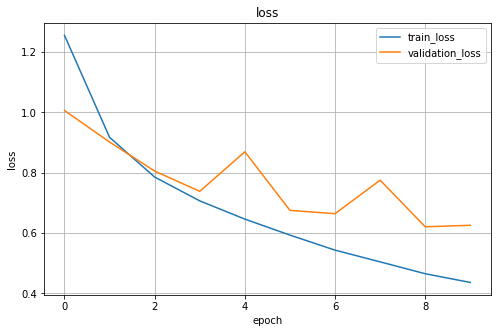

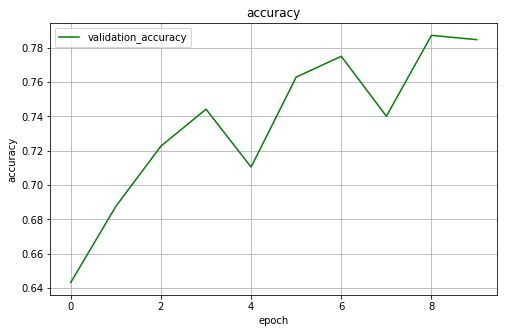

In [11]:
# 学習ログ(lossとaccuracy)の表示
plt.figure(figsize=(8,5))
plt.plot(loss_list, label = 'train_loss')
plt.plot(val_loss_list, label = 'validation_loss')
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(val_acc_list, 'g-',label='validation_accuracy')
plt.title('accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

In [12]:
# モデルの重みの読み込み
if use_gpu:
    params = torch.load(DIRNAME + 'CNN_CIFAR10.pth')
else:
    params = torch.load(DIRNAME + 'CNN_CIFAR10.pth', map_location = 'cpu')
net = CNN_CIFAR10()
net.load_state_dict(params)
if use_gpu:
    net.cuda()

In [13]:
# 読み込んだ学習済みモデルを使って推論のテスト
# 本当はハイパーパラメータの調整のために用いたvalidationデータは学習において使用されているに等しいので、
# テストデータとして用いるべきではないが、今回は簡単のためひとまず同じものでテスト
net.eval()
cifar10_test = datasets.CIFAR10(root = './data',
                            train = False,
                            transform = tf)
# 同じ正規化を採用すること
cifar10_test_loader = DataLoader(cifar10_test, batch_size = 100, shuffle = True)
inputs, targets = iter(cifar10_test_loader).next()
if use_gpu:
    inputs = inputs.cuda()
outputs = net(inputs)
_, preds = torch.max(outputs, 1)
preds = preds.cpu() # 比較時の型は等しくないといけないのでcpuに戻す
accuracy = (preds == targets).float().sum() / targets.size(0)
print(accuracy)

tensor(0.7500)


tensor([[3, 7, 6, 3, 5],
        [5, 9, 5, 0, 0],
        [0, 1, 3, 6, 5],
        [4, 2, 5, 9, 5],
        [1, 0, 8, 7, 4]])
[['cat' 'horse' 'frog' 'cat' 'dog']
 ['dog' 'truck' 'dog' 'plane' 'plane']
 ['plane' 'car' 'cat' 'frog' 'dog']
 ['deer' 'bird' 'dog' 'truck' 'dog']
 ['car' 'plane' 'ship' 'horse' 'deer']]


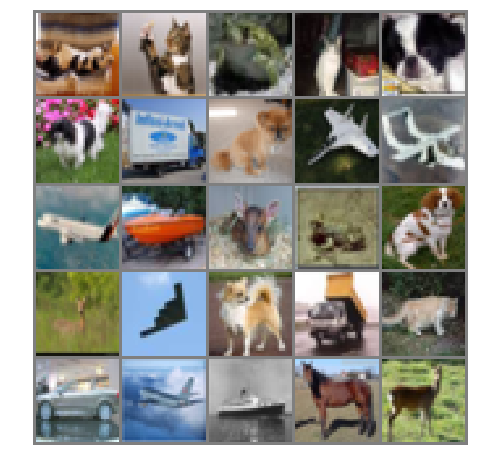

In [14]:
# 推論結果の可視化
s = 20
images, labels = inputs.cpu()[s:s + n_show], preds[s:s + n_show]
labels_name = np.array([classes[l] for l in labels.numpy()]).reshape(n_row, n_row)
imshow(make_grid(images, nrow = n_row, padding = 1))
plt.axis('off')
print(labels.view(-1, n_row))
print(labels_name.reshape(n_row, n_row))

正解
['ship', 'deer', 'deer', 'bird']
['deer', 'dog', 'ship', 'cat']
['deer', 'cat', 'car', 'ship']
['dog', 'plane', 'dog', 'bird']
['deer', 'frog', 'deer', 'truck']
['cat']
間違った結果
['plane', 'bird', 'bird', 'deer']
['horse', 'cat', 'car', 'bird']
['dog', 'frog', 'truck', 'truck']
['cat', 'bird', 'horse', 'frog']
['ship', 'bird', 'dog', 'plane']
['dog']


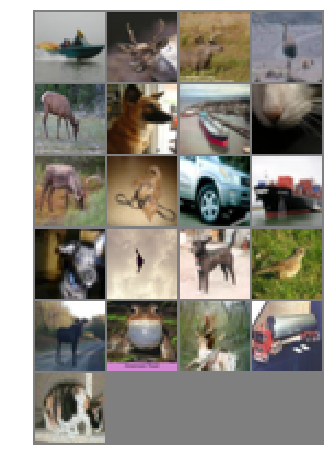

In [15]:
# どんな画像について間違えたのか表示してみよう
wrong_images= []
wrong_labels = []
correct_labels = []
row = 4
inputs, targets = iter(cifar10_test_loader).next()
if use_gpu:
    inputs = inputs.cuda()
outputs = net(inputs)
_, preds = torch.max(outputs, 1)
preds = preds.cpu()
for i, t, p in zip(inputs, targets, preds):
    if t != p:
        wrong_images.append(i.cpu())
        wrong_labels.append(p.cpu().item())
        correct_labels.append(t.cpu().item())
imshow(make_grid(wrong_images, nrow = row, padding = 1))
correct_labels_name = [classes[l] for l in correct_labels]
wrong_labels_name = [classes[l] for l in wrong_labels]
plt.axis('off')
print('正解')
for l in range(0, len(wrong_images), row):
    print(correct_labels_name[l:l+row])
print('間違った結果')
for l in range(0, len(wrong_images), row):
    print(wrong_labels_name[l:l+row])